In [ ]:
# basic ML library import
%matplotlib inline
import numpy as np 
import pandas as pd
import regex as re
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder
import gc
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype

import os

# M5 compeition Summary
https://www.kaggle.com/c/m5-forecasting-accuracy
This contest was to predict the amount of sales for each individual item that would be sold in an indidual Walmart. There was a companion competition to predict a range of sales, we will save an analysis of that contest for another notebook.

Solutions thread: https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/163414

# Brief overview of time series and grouped time series
### The M5 contest is a grouped time series problem. 

**In a time series problem the history of something is available, and the task is to predict the next interval.**

 * Basic examples: predict how many people will ride the subway in a city on a given day, what price a stock will close at tomorrow, how many inches of rain will fall next month, etc etc... 
 * In technical terms, the main twist of time series from other ML problems are how test and training data are split. If the data is split randomly (using something like sk-learn train test split), then the model will be allowed to "cheat" during training. Training must be done on the earlier dated data, and testing must be done on later data.
  * For example if you were trying to predictthe price that a stock cloed at on Tuesday it would be much easier to do this if you know the price on Monday and Wednesday.

**A grouped time series problem adds more complexity to time series in that there are many different things that often have similiarties, but are distinct from each other.**

 * In this contest the goal is to predict sales of individual items in individual stores. Many items sell more during holiday seasons, others are more affected by days of the week, etc.
 * [Grandmaster Filho](https://www.kaggle.com/mariofilho) has a good [explaner article on the basics of grouped time series](https://www.mariofilho.com/how-to-predict-multiple-time-series-with-scikit-learn-with-sales-forecasting-example/)
  * This article covers many of the ideas in this notebook.
  * Also searching grouped time series on the Towards Data Science blog will [return many good articles](https://www.google.com/search?q=grouped+time+series+towards+data+science&rlz=1C1GCEA_enUS879US879&oq=grouped+time+series+towards+data+science&aqs=chrome..69i57.4977j0j1&sourceid=chrome&ie=UTF-8)

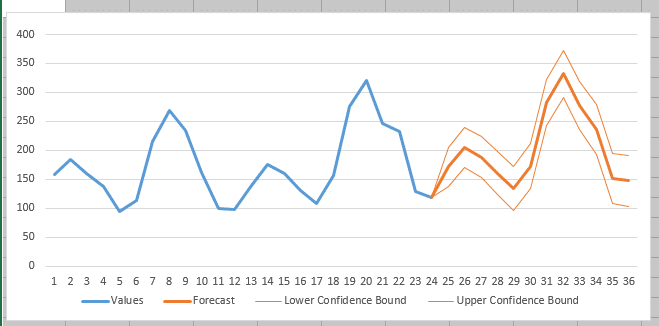

# Baseline (non-ML) model
[Extremel simple grouped by weekday](https://www.kaggle.com/chrisrichardmiles/simple-model-avg-last-28-days-grouped-by-weekday) is a great example of a simple baseline that makes very good predictions, here it only had a 0.75 error, which puts it at about 850 out of 5,550 entries into the contest.

#### If you remember nothing else... remember to always compare any model to a simple baseline...

# Look at and clean the data
The sales training data was given in what looks like a form that is more suited to reporting rather than to useful for ML or to be stored in a database. This reporting format required that the data needed to be manipulated using melt and pivot functionalities found in Pandas. It also required other manipulaitons to convert non-numeric data to numeric data so that it can be used by ML models.

### The data starts like this:

In [ ]:
df_sales_train = pd.read_csv('../input/m5-forecasting-accuracy/sales_train_validation.csv')
df_sales_train.head()

In [ ]:
df_sales_train.columns

### After manipulations and merging other data to it, ends like this:

In [ ]:
df_train = pd.read_pickle('../input/end-to-end-data-wrangling-simple-random-forest/df_train_pickle.pkl')
df_train.head()

In [ ]:
df_train.columns

### Notes on the resulting cleaned data
After doing some processing in [this notebook that I wrote](https://www.kaggle.com/beezus666/end-to-end-data-wrangling-simple-random-forest) the data winds up in a format that can be used by an ML model. This notebook is a good example of fundamental data cleaning and preperation techniques taught in these courses:
* https://www.kaggle.com/learn/pandas
* https://www.kaggle.com/learn/data-cleaning
* https://course18.fast.ai/ml.html
 * This Fast.ai course is my personal favorite... it is long but from just the first few lessons it will give a mastery of data cleaning and tree-based models.

### Notes on the resulting submission/model
The submission from the notebook ranked in the top 50%... not great, but not bad for just doing the absolute basics and minimum.
* I did no feature engineering, simply taking the data as it was as and formatting it so it could be used in a model
* The notebook used a very basic out of the box random forest, where it has been shown in the competition that lightGBM was the best choice.


# Lag features

Usually, the first step in improving a time series problem is creating features, usually those are lag features.

### What are lag features?
* "A lag features is a fancy name for a variable which contains data from prior time steps. If we have time-series data, we can convert it into rows. Every row contains data about one observation and includes all previous occurrences of that observation."
 * https://www.mikulskibartosz.name/forecasting-time-series-using-lag-features/
* [This article](https://www.mariofilho.com/how-to-predict-multiple-time-series-with-scikit-learn-with-sales-forecasting-example/) has a number of examples of how to create simple lag features. 
 * Some exaplles of lag features are just simply looking at yesterday/2 days ago/last week. Moving summed stats like mean, median and standard deviation.


### [Grandmaster Konstantin](https://www.kaggle.com/kyakovlev/notebooks?userId=2405813&sortBy=voteCount&tab=profile) 
This grandmaster created and shared a series of notebooks the one that we'll talk about now is this one:
### [Konstantin's lag features notebook](https://www.kaggle.com/kyakovlev/m5-lags-features)
This notebook goes through how to create lags for this competition with the given data. 

Similar to Filho's article the example code uses lines like these:

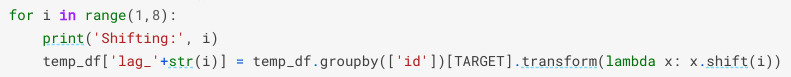

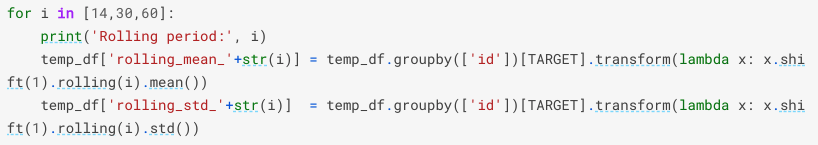

The key things to note here are:
* Grouping by id, because it's a grouped time series
* Use of shift to make the lag
* Use of .mean and .std to make aggregated lags
* This particular snippet code is using a range and loop to make simple lags for 1-8 days, and aggregated lags for 14, 30, and 60 days

# Top solutions
* [1st place](https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/163684) used lightGBM many features
* [2nd place](https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/164599) used a huge ensemble of LightGBM with different paramaters, tweedie loss
* [3rd place](https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/164374) used DeepAR tweedie loss

All used Tweedie loss...
[Good article explaining improving a lightGBM model by using tweedie loss.](https://medium.com/@royravid/have-you-heard-about-tweedie-loss-bb94551dd82f) Essentially tweedie is a distribution with a large number of zeros, and then something that looks like a normal curve after. e.g. the amount of money individuals spend who go to Amazon.com on a given day.

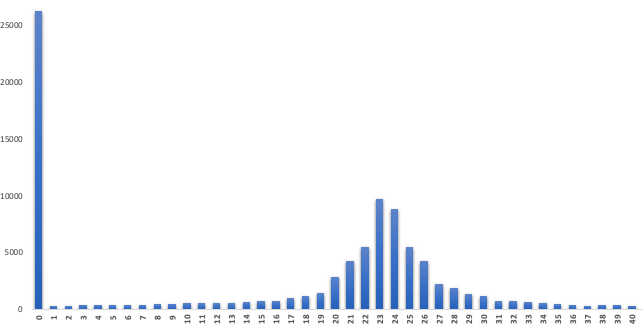